In [59]:
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)

## Introduction:
The data set we are working on is the bank marketing data set. The bank we are analyzing is a Portuguese banking institution with data related with direct marketing campaigns (phone calls).

This dataset contains many variables as shown when we load the file below. However some of the more cryptic variables are defined here:

- `default` - Has credit in default?
- `balance` - Account balance (EUR)
- `housing` - Has housing loan?
- `contact` - Contact communication type
- `month` / `day_of_week` - Date of last contact
- `duration` - Last contact duration, in seconds
- `campaign` - Number of contacts performed during this campaign and for this client
- `pdays` - Number of days that passed by after the client was last contacted from a previous campaign
- `previous` - Number of contacts performed before this campaign and for this client 
- `poutcome` - Outcome of the previous marketing campaign
- `y` - Has the client subscribed a term deposit?

Using this dataset we will attempt to answer the question "Which variables have the greatest influence on predicting whether or not a client will subscribe a term deposit?" A term deposit is a cash investment held at a financial institution. Your money is invested for an agreed rate of interest over a fixed amount of time, or term.

## Method:

Quick summary of method

##### In the next cell we load our data from the web

In [60]:
# set seed
set.seed(1337)

# download and extract dataset
dir.create("data/")
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip", destfile = "data/bank.zip")
unzip("data/bank.zip", files = "bank-full.csv", exdir = "data/", overwrite = TRUE)

# load dataset
bank_full <- read_delim("data/bank-full.csv", delim = ';')
slice(bank_full, 1:10)

Warning message in dir.create("data/"):
“'data' already exists”
Parsed with column specification:
cols(
  age = col_double(),
  job = col_character(),
  marital = col_character(),
  education = col_character(),
  default = col_character(),
  balance = col_double(),
  housing = col_character(),
  loan = col_character(),
  contact = col_character(),
  day = col_double(),
  month = col_character(),
  duration = col_double(),
  campaign = col_double(),
  pdays = col_double(),
  previous = col_double(),
  poutcome = col_character(),
  y = col_character()
)



age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no


##### In the following set we convert all of our variables to numbers and mark NA for unknown values

In [61]:

bank_fixed = bank_full
bank_fixed = mutate(bank_fixed, across(where(is.character), ~na_if(., "unknown")))
bank_fixed = mutate(bank_fixed, pdays = na_if(pdays, -1))
bank_fixed$job = as.numeric(as.factor(bank_fixed$job))
bank_fixed$marital = as.numeric(as.factor(bank_fixed$marital))
bank_fixed$education = as.numeric(as.factor(bank_fixed$education))
bank_fixed$default = as.numeric(as.factor(bank_fixed$default))
bank_fixed$housing = as.numeric(as.factor(bank_fixed$housing))
bank_fixed$loan = as.numeric(as.factor(bank_fixed$loan))
bank_fixed$contact = as.numeric(as.factor(bank_fixed$contact))
bank_fixed$month = as.numeric(as.factor(bank_fixed$month))
bank_fixed$poutcome = as.numeric(as.factor(bank_fixed$poutcome))
bank_fixed$y = as.numeric(as.factor(bank_fixed$y))
bank_factor = mutate(bank_fixed, y = as_factor(y))
slice(bank_fixed, 1:5)

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
58,5,2,3,1,2143,2,1,NA,5,9,261,1,NA,0,NA,1
44,10,3,2,1,29,2,1,NA,5,9,151,1,NA,0,NA,1
33,3,2,2,1,2,2,2,NA,5,9,76,1,NA,0,NA,1
47,2,2,NA,1,1506,2,1,NA,5,9,92,1,NA,0,NA,1
33,NA,3,NA,1,1,1,1,NA,5,9,198,1,NA,0,NA,1


##### In the next cell we install resources for corelation table

In [62]:
install.packages("corrplot")
source("http://www.sthda.com/upload/rquery_cormat.r")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



##### Correlation Table:

$r
          marital     job education duration poutcome       y balance     day
marital         1                                                            
job          0.07       1                                                    
education    0.14    0.17         1                                          
duration  -0.0071   0.023   -0.0031        1                                 
poutcome    0.047   0.063     0.081     0.11        1                        
y           0.051   0.078      0.11     0.35     0.42       1                
balance    -0.023   0.038     0.079    0.041    0.051   0.079       1        
day         0.015   0.016     0.018  -0.0066    0.015    0.03   0.048       1
housing    -0.051   -0.12     -0.12   -0.072    -0.29   -0.32   -0.11  -0.071
pdays     -0.0066   -0.11     -0.16  -0.0096    -0.24   -0.15    -0.1   -0.09
default   -0.0029  -0.019    -0.011  -0.0061   -0.025  -0.032  -0.045 -0.0013
loan       -0.056  -0.028    -0.031   -0.035    -0.11   -0.12

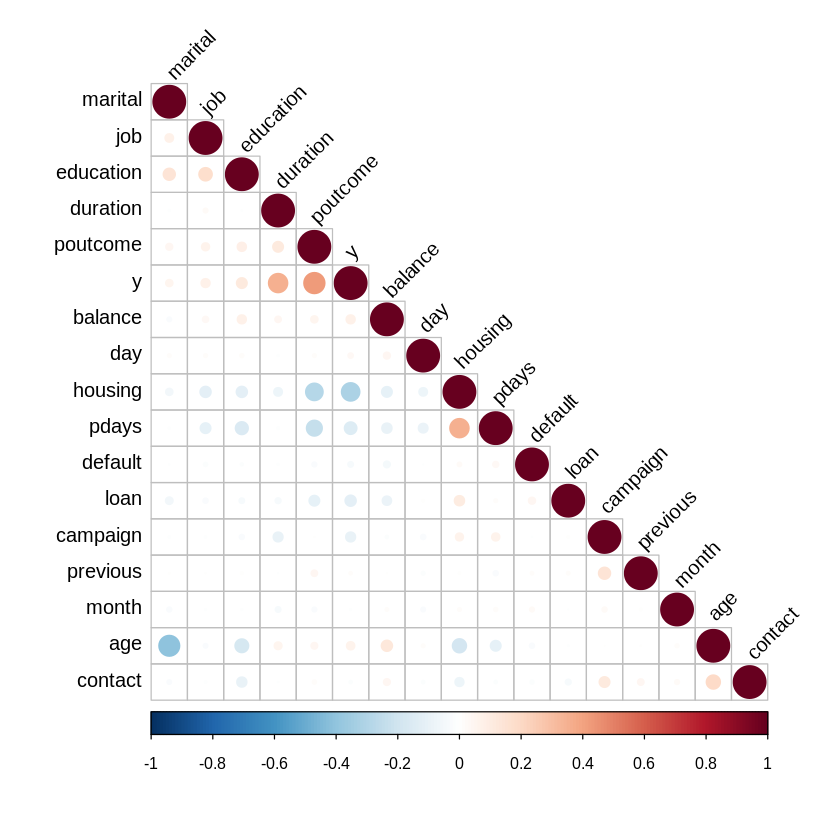

In [63]:
# print corelation table
rquery.cormat(bank_fixed)

##### Creating model and specification:

In the next cell code we create the specification needed for our algorithm

In [64]:
# create knn model
knn_spec = nearest_neighbor(weight_func = "rectangular") %>%
       set_engine("kknn") %>%
       set_mode("classification")

knn_fit = knn_spec %>% 
       fit(y ~ age:poutcome, data = bank_factor)

knn_spec
knn_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  weight_func = rectangular

Computational engine: kknn 


parsnip model object

Fit time:  400ms 

Call:
kknn::train.kknn(formula = y ~ age:poutcome, data = data, ks = 5,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2077072
Best kernel: rectangular
Best k: 5

To test our algorithm we create a tibble and assign the built in predict function to it. This step is solely to make sure of model runs and does not help us in answering our predictive question.

In [65]:
# test knn model (not nessisary just want to make sure it works)

# age = 58, job = "management", marital = "married", education = "tertiary", default = "no", balance = 2143, housing = "yes", loan = "no", contact = "unknown", day = 5,
#    month = "may", duration = 261, campaign = 1, pdays = -1, previous = 0, poutcome = "unknown"
new_obs <- tibble(age = 58, job = 5, marital = 2, education = 3, default = 1, balance = 2143, housing = 2, loan = 1, contact = NA,
                  day = 5, month = 9, duration = 261, campaign = 1, pdays = NA, previous = 0, poutcome = 4)

class_prediction <- predict(knn_fit, new_obs)
class_prediction

.pred_class
<fct>
2


##### Before we begin to test which variable plays the greatest influence on whether a client subscribes to the credit card or not, we must first split our data into a training and testing set and than scale all the factors in our training set.

In [66]:
set.seed(1)
bank_split <- initial_split(bank_factor, prop = 0.75, strata = y)
bank_train <- training(bank_split)
bank_test <- testing(bank_split)

##### To view our data we use the built in glimpse function

In [67]:
glimpse(bank_train)

Rows: 33,909
Columns: 17
$ age       <dbl> 58, 44, 33, 47, 33, 35, 42, 58, 43, 41, 29, 53, 58, 51, 60,…
$ job       <dbl> 5, 10, 3, 2, NA, 5, 3, 6, 10, 1, 1, 10, 10, 6, 6, 2, 5, 2, …
$ marital   <dbl> 2, 3, 2, 2, 3, 2, 1, 2, 3, 1, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2,…
$ education <dbl> 3, 2, 2, NA, NA, 3, 3, 1, 2, 2, 2, 2, NA, 1, 1, 2, 3, 1, 1,…
$ default   <dbl> 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ balance   <dbl> 2143, 29, 2, 1506, 1, 231, 2, 121, 593, 270, 390, 6, 71, 22…
$ housing   <dbl> 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,…
$ loan      <dbl> 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1,…
$ contact   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ day       <dbl> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,…
$ month     <dbl> 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,…
$ duration  <dbl> 261, 151, 76, 92, 198, 139, 380, 50, 55, 222, 137, 517, 71,…
$ campaign  <dbl> 1, 1, 1, 

In [68]:
glimpse(bank_train)

Rows: 33,909
Columns: 17
$ age       <dbl> 58, 44, 33, 47, 33, 35, 42, 58, 43, 41, 29, 53, 58, 51, 60,…
$ job       <dbl> 5, 10, 3, 2, NA, 5, 3, 6, 10, 1, 1, 10, 10, 6, 6, 2, 5, 2, …
$ marital   <dbl> 2, 3, 2, 2, 3, 2, 1, 2, 3, 1, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2,…
$ education <dbl> 3, 2, 2, NA, NA, 3, 3, 1, 2, 2, 2, 2, NA, 1, 1, 2, 3, 1, 1,…
$ default   <dbl> 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ balance   <dbl> 2143, 29, 2, 1506, 1, 231, 2, 121, 593, 270, 390, 6, 71, 22…
$ housing   <dbl> 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,…
$ loan      <dbl> 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1,…
$ contact   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ day       <dbl> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,…
$ month     <dbl> 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,…
$ duration  <dbl> 261, 151, 76, 92, 198, 139, 380, 50, 55, 222, 137, 517, 71,…
$ campaign  <dbl> 1, 1, 1, 

K-NN is sensitive to the scale of the predictors, and so we should perform some preprocessing to standardize them. An additional consideration we need to take when doing this is that we should create the standardization preprocessor using only the training data. This ensures that our test data does not influence any aspect of our model training. Once we have created the standardization preprocessor, we can then apply it separately to both the training and test data sets.

## Create a new recipe and specification for every individual variable

##### This specification can be used for every variable:

In [69]:
knn_specification <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
  set_engine("kknn") %>%
  set_mode("classification")

#### Accuracy of "marital" variable as a predictor:

In [70]:
bank_recipe_marital <- recipe(y ~ marital, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_marital <- workflow() %>%
    add_recipe(bank_recipe_marital) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

In [71]:
bank_test_predictions_marital <- predict(knn_fit_marital, bank_test) %>%
  bind_cols(bank_test)

marital_pred = bank_test_predictions_marital %>%
  metrics(truth = y, estimate = .pred_class)
marital_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8830296
kap,binary,0.0000000


##### From the above cell we see that when we use the "marital" variable as our predictor, we yeild a 88.3% accuracy

#### Accuracy of "education" variable as a predictor: not working due to na in data set

In [76]:
bank_recipe_education <- recipe(y ~ education, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_education <- workflow() %>%
    add_recipe(bank_recipe_education) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

In [78]:
#bank_test_predictions_education <- predict(knn_fit_education, bank_test) %>%
#  bind_cols(bank_test)

#bank_test_predictions_education %>%
#  metrics(truth = y, estimate = .pred_class)

#### Accuracy of "default" variable as a predictor:

In [72]:
bank_recipe_default <- recipe(y ~ default, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_default <- workflow() %>%
    add_recipe(bank_recipe_default) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

In [73]:
bank_test_predictions_default <- predict(knn_fit_default, bank_test) %>%
  bind_cols(bank_test)

default_pred = bank_test_predictions_default %>%
  metrics(truth = y, estimate = .pred_class)

default_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8830296
kap,binary,0.0000000


#### Accuracy of "age" variable as a predictor:

In [74]:
bank_recipe_age <- recipe(y ~ age, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_age <- workflow() %>%
    add_recipe(bank_recipe_age) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

In [75]:
bank_test_predictions_age <- predict(knn_fit_age, bank_test) %>%
  bind_cols(bank_test)

age_pred = bank_test_predictions_age %>%
  metrics(truth = y, estimate = .pred_class)

age_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.88241019
kap,binary,0.03550441


#### Accuracy of "balance" variable as a predictor:

In [79]:
bank_recipe_balance <- recipe(y ~ balance, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_balance <- workflow() %>%
    add_recipe(bank_recipe_balance) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

In [80]:
bank_test_predictions_balance <- predict(knn_fit_balance, bank_test) %>%
  bind_cols(bank_test)

balance_pred = bank_test_predictions_balance %>%
  metrics(truth = y, estimate = .pred_class)

balance_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.87126172
kap,binary,0.04781843


#### Accuracy of "housing" variable as a predictor:

In [81]:
bank_recipe_housing <- recipe(y ~ housing, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_housing <- workflow() %>%
    add_recipe(bank_recipe_housing) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

In [82]:
bank_test_predictions_housing <- predict(knn_fit_housing, bank_test) %>%
  bind_cols(bank_test)

housing_pred = bank_test_predictions_housing %>%
  metrics(truth = y, estimate = .pred_class)

housing_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8830296
kap,binary,0.0000000


#### Accuracy of "loan" variable as a predictor:

In [83]:
bank_recipe_loan <- recipe(y ~ loan, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_loan <- workflow() %>%
    add_recipe(bank_recipe_loan) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

In [84]:
bank_test_predictions_loan <- predict(knn_fit_loan, bank_test) %>%
  bind_cols(bank_test)

loan_pred = bank_test_predictions_loan %>%
  metrics(truth = y, estimate = .pred_class)

loan_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8830296
kap,binary,0.0000000


#### Accuracy of "day" variable as a predictor:

In [85]:
bank_recipe_day <- recipe(y ~ day, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_day <- workflow() %>%
    add_recipe(bank_recipe_day) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

In [86]:
bank_test_predictions_day <- predict(knn_fit_day, bank_test) %>%
  bind_cols(bank_test)

day_pred = bank_test_predictions_day %>%
  metrics(truth = y, estimate = .pred_class)

day_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8830296
kap,binary,0.0000000
